In [7]:
#Model getting the CFFs
import numpy as np
import math
from scipy.integrate import quad as quadd
import fucntiondvcs as fnctt
#from scipy.integrate import romberg as quadd

#https://stackoverflow.com/questions/52693899/numerical-integration-with-singularities-in-python-principal-value 
#constants, kine is array of kinematics
#QQ[1.49, 8.51], xB[0.33, 0.62], t[-1.37, -0.17], k = 5.75
#QQ,xB,t,k=2,.33,-1.,5.75
#kine=[QQ,xB,t,k]
def ModKM15_CFFs(QQ,xB,t,k):
    # KM09b parameters
    nval = 1.35;pval = 1.;nsea = 1.5;rsea = 1.;psea = 2.;bsea = 4.6
    #KM15 parameters
    Mval = 0.789;rval = 0.918;bval = 0.4;C0 = 2.768;Msub = 1.204;Mtval = 3.993;rtval = 0.881;btval = 0.4;ntval = 0.6
    # sea H
    Msea = np.sqrt(0.482)
    # "pion pole" Etilde
    rpi = 2.646;Mpi = 4.
#    QQ = kine[0]     #Q^2 value
#    xB = kine[1]      #Bjorken x
#    t = kine[2]      #momentum transfer squared
#    k = kine[3]      #Electron Beam energy
    alpha_val = 0.43 + 0.85 * t
    alpha_sea = 1.13 + 0.15 * t
    Ct = C0/(1.-t/Msub**2)**2 
    xi = xB /(2.- xB) # Generalized Bjorken variable KM09
    def fHval(x): 
        if ((2*x/(1+x)))==0:
            return 0
        else:
            return (nval *rval)/(1.+x)* (2*x/(1+x))**(-alpha_val)* ((1-x)/(1+x))**bval*1./(1.-(1.-x)/(1.+x)*t/Mval**2)**(pval) 
    def fHsea(x): 
        if ((2.* x)/(1.+x))==0:
            return 0
        else:
            return ((nsea*rsea)/( 1.+x)* ((2.* x)/(1.+x))**(-alpha_sea)* ((1.-x)/(1.+x))**(bsea)*
                    1./(1.-(1.-x)/(1.+x)*t/Msea**2)**(psea))
    def fHtval(x):
        if (2*x/(1+x))==0:
            return 0
        else:
            return (ntval* rtval)/(1.+x)* (2*x/(1+x))**(-alpha_val)* ((1-x)/(1+x))**btval* 1./(1.-(1.-x)/(1.+x)*t/Mtval**2)
    def fImH(x): 
        return np.pi*((2.*(4./9.)+ 1./9.)*fHval(x)+2./9 *fHsea(x))
    def fImHt(x):
        return np.pi* (2.*(4./9.)+1./9.) *fHtval(x)
    # Real part of the CFFs (H, Htilde)
    def fPV_ReH(x):
        return -2.*x/ (x+ xi)*fImH(x)
    
    def fPV_ReHt(x):
        return -2.*xi/(x+xi) *fImHt(x)
    #cauchy stuff, note the [0] at end is to take only the first part. 
    DR_ReHreal=(quadd(lambda x:(-2.*x/(x+ xi)*fImH(x)).real,.0000001,1,weight='cauchy',wvar=xi))[0]
    DR_ReHimag=(quadd(lambda x:(-2.*x/(x+ xi)*fImH(x)).imag,.0000001,1,weight='cauchy',wvar=xi))[0]
    #+quadd((fPV_ReH).imag,0,1,weight='cauchy',wvar=xi)
    #DR_ReHt=quadd((fPV_ReHt),0.0001,1,weight='cauchy',wvar=xi)
    DR_ReHtreal=(quadd(lambda x:(-2.*xi/(x+xi) *fImHt(x)).real,.0000001,1,weight='cauchy',wvar=xi))[0]
    DR_ReHtimag=(quadd(lambda x:(-2.*xi/(x+xi) *fImHt(x)).imag,.0000001,1,weight='cauchy',wvar=xi))[0]
    #+quadd((fPV_ReHt).imag,0,1,weight='cauchy',wvar=xi)
#    ig.SetFunction(fPV_ReH)
#    DR_ReH = ig.IntegralCauchy(1.e-279, 1., xi)
#    ig.SetFunction(fPV_ReHt)
#    DR_ReHt = ig.IntegralCauchy(1.e-323, 1., xi)
    
 #   i1 = quad(lambda x: -1./(x+1), 0, 2, weight='cauchy', wvar=1)[0]
    # Evaluate the CFFs
    cff=[fImH(xi),1./np.pi* complex(DR_ReHreal,DR_ReHimag)-Ct,Ct,fImHt(xi),1./math.pi* complex(DR_ReHtreal,DR_ReHtimag),
         rpi/ xi*2.164/((0.0196-t)* (1.-t/Mpi**2)**2 ) ]
    return cff
#note that ImE,ImEtilde=0,0
#ImH,ReH,ReE,ImHtilde,ReHtilde,ReEtilde=ModKM15_CFFs(kine)
#hop=ModKM15_CFFs(QQ,xB,t,k)
#print(hop)

In [6]:
#Model for BHLL and BHUU
electronthing,lambdae,LambdaP=1,1,1
def consts(y,M,QQ,xB):
    fnst=1/137.0359998
    return fnst**3*xB*y**2/(8*np.pi*QQ**2*np.sqrt(1+Gamma(xB,M,QQ)**2))
def Gamma(xB,M,QQ):
    return 2*xB*M/np.sqrt(QQ)
def F1(t,M):
    GE=1/(1-t/.71)**2
    GM=2.79*GE
    out =(GE-t/(4*M**2)*GM)/(1-t/(4*M**2))
    return out
def F2(t,M):
    GE=1/(1-t/.71)**2
    GM=2.79*GE
    out =(-GE+GM)/(1-t/(4*M**2))
    return out
#y=QQ/(k*2*M*xB)
#phi=2
def xiold(xB,t,QQ): # Generalized Bjorken variable
    return xb*(1.+t/2./QQ)/ (2.- xb + xb*t/ QQ)
'''tmin = (- QQ * (2. * (1. - xb) * (1. - np.sqrt(1. + Gamma(xB,M,QQ)**2)) + Gamma(xB,M,QQ)**2) / 
        (4. * xb * (1. - xb) + Gamma(xB,M,QQ)**2))  # eq. (31)
Ktilde_10 = (np.sqrt(tmin - t) * 
             np.sqrt((1. -xb)*np.sqrt(1.+Gamma(xB,M,QQ)**2)+((t-tmin)*(Gamma(xB,M,QQ)**2+4. * xb * (1. - xb)) / 4. / QQ))
             * np.sqrt(1.-y-y* y* Gamma(xB,M,QQ)**2 / 4.) /tf.sqrt(1.-y+y*y*Gamma(xB,M,QQ)**2/4.)) # K tilde from 2010 paper
K = np.sqrt(1. - y + y * y * Gamma(xB,M,QQ)**2 / 4.) * Ktilde_10 /np.sqrt(QQ)'''
def P1(y,M,QQ,xB,t,phi,K): #note phi is in degrees here 
    KD=(-QQ/(2. *y*(1.+Gamma(xB,M,QQ)**2))*
        (1.+2.*K*np.cos(np.pi-(phi *np.pi/180)) #convert from degrees to radians
         - t/ QQ * (1. - xB * (2. - y) + y * Gamma(xB,M,QQ)**2 / 2.) + y * Gamma(xB,M,QQ)**2 / 2.))  # eq. (29)
    return 1. + 2. * KD / QQ
def P2(y,M,QQ,xB,t,phi,K): #note phi is in degrees here 
    KD=(-QQ/(2. *y*(1.+Gamma(xB,M,QQ)**2))*
        (1.+2.*K*np.cos(np.pi-(phi *np.pi/180)) #convert from degrees to radians
         - t/ QQ * (1. - xB * (2. - y) + y * Gamma(xB,M,QQ)**2 / 2.) + y * Gamma(xB,M,QQ)**2 / 2.))  # eq. (29)
    return t / QQ - 2. * KD / QQ
def BHUU(y,M,QQ,xB,t,phi): #note that phi is in degrees here 
    x=xB;xb=xB
    def mysqrt(x): return np.sqrt((1.+0j)*x)
    tmin = (- QQ * (2. * (1. - xb) * (1. - np.sqrt(1. + Gamma(xB,M,QQ)**2)) + Gamma(xB,M,QQ)**2) / 
            (4. * xb * (1. - xb) + Gamma(xB,M,QQ)**2))  # eq. (31)
    Ktilde_10 = (mysqrt(tmin - t) * 
                 mysqrt((1. -xb)*mysqrt(1.+Gamma(xB,M,QQ)**2)+((t-tmin)*(Gamma(xB,M,QQ)**2+4. * xb * (1. - xb)) / 4. / QQ))
                 * mysqrt(1.-y-y* y* Gamma(xB,M,QQ)**2 / 4.) /mysqrt(1.-y+y*y*Gamma(xB,M,QQ)**2/4.)) # K tilde from 2010 paper
    K = mysqrt(1. - y + y * y * Gamma(xB,M,QQ)**2 / 4.) * Ktilde_10 /np.sqrt(QQ)
    c0_BH =8.*K*K*((2.+3.* Gamma(xB,M,QQ)**2)*(QQ/t)*(F1(t,M) * F1(t,M) - F2(t,M) * F2(t,M) * t / (4. * M**2)) + 2. * x * x * (F1(t,M) + F2(t,M)) * (F1(t,M) + F2(t,M))) + (2. - y) * (2. - y) * ((2. + Gamma(xB,M,QQ)**2) * (
                (4. * x * x * M**2 / t) * (1. + t / QQ) * (
                    1. + t / QQ) 
                    + 4. * (1. - x) * (1. + x * t / QQ)) * (F1(t,M) * F1(t,M) - F2(t,M) * F2(t,M) * t / (4. * M**2)) + 4. * x * x * (x + (1. - x + Gamma(xB,M,QQ)**2 / 2.) * (1. - t / QQ) * (1. - t / QQ) - x* (1. - 2. * x) * t * t / (QQ * QQ)) * (F1(t,M) + F2(t,M))**2) + 8. * (
                             1. + Gamma(xB,M,QQ)**2) * (1. - y - Gamma(xB,M,QQ)**2 * y * y / 4.) * (
                             2. * Gamma(xB,M,QQ)**2 * (1. - t / (4. * M**2)) * (
                                 F1(t,M) * F1(t,M) - F2(t,M) * F2(t,M) * t / (4. * M**2)) - x * x * (
                                         1. - t / QQ) * (1. - t / QQ) * (F1(t,M) + F2(t,M)) * (F1(t,M) + F2(t,M)))

    c1_BH = 8. * K * (2. - y) * (
                (4. * x * x * M**2 / t - 2. * x - Gamma(xB,M,QQ)**2) * (
                    F1(t,M) * F1(t,M) - F2(t,M) * F2(t,M) * t / (4. * M**2)) + 2. * x * x * (
                            1. - (1. - 2. * x) * t / QQ) * (F1(t,M) + F2(t,M)) * (F1(t,M) + F2(t,M)))

    c2_BH = 8. * x * x * K * K * (
                (4. * M**2 / t) * (F1(t,M) * F1(t,M) - F2(t,M) *F2(t,M) * t / (4. * M**2)) + 2. * (F1(t,M) + F2(t,M)) * (
                    F1(t,M) + F2(t,M)))

    # BH squared amplitude eq (25) divided by e^6
    Amp2_BH = 1. / (x * x * y * y * (1. + Gamma(xB,M,QQ)**2) * (
                1. + Gamma(xB,M,QQ)**2) * t * P1(y,M,QQ,xB,t,phi,K) * P2(y,M,QQ,xB,t,phi,K)) * (c0_BH + c1_BH * np.cos(
        np.pi - (phi * np.pi/180)) + c2_BH * np.cos(2. * (np.pi - (phi * np.pi/180))))

    #Amp2_BH = self.GeV2nb * Amp2_BH  # convertion to nb
    return Amp2_BH*389.39*1000*consts(y,M,QQ,xB)
#first 2 unknown is 1,1.   delta is in paper, S=1,eee=1
def CBHLP0(y,M,QQ,xB,t,phi,lambdae,LambdaP,K):
    Delta2=(P2(y,M,QQ,xB,t,phi,K)-P1(y,M,QQ,xB,t,phi,K))**2
    out2=(1/2*(xB/2*(1-Delta2/QQ)-Delta2/4/M**2)*(2-xB-2*(1-xB)**2*Delta2/QQ
         +Gamma(xB,M,QQ)**2*(1-Delta2/QQ)-xB*(1-2*xB)*Delta2**2/QQ**2)*(F1(t,M)+F2(t,M)))
    out22=((1-(1-xB)*Delta2/QQ)*(xB**2*M**2/Delta2*(1+Delta2/QQ)**2+(1+xB)*(1+xB*Delta2/QQ))
          *(F1(t,M)+F2(t,M)*Delta2/4/M**2))
    out1=(8*lambdae*LambdaP*xB*(2-y)*y*np.sqrt(1+Gamma(xB,M,QQ)**2)/(1-Delta2/(4*M**2))*(F1(t,M)+F2(t,M)))
    return out1*(out2+out22) 
def CBHLP1(y,M,QQ,xB,t,phi,lambdae,LambdaP,K):
    Delta2=(P2(y,M,QQ,xB,t,phi,K)-P1(y,M,QQ,xB,t,phi,K))**2
    out1=(8*lambdae*LambdaP*xB*y*K*np.sqrt(1+Gamma(xB,M,QQ)**2)/(1-Delta2/(4*M**2))*(F1(t,M)+F2(t,M)))
    out2=((Delta2/2/M**2-xB*(1-Delta2/QQ)**2)*(1-xB+xB*Delta2/QQ)*(F1(t,M)+F1(t,M)))
    out222= 1+xB-(3-2*xB)*(1+xB*Delta2/QQ)-4*xB**2*M**2/Delta2*(1+Delta2**2/QQ**2)*(F1(t,M)+F1(t,M)*Delta2/4/M**2)
    return out1*(out2+out222)
def BHLL(y,M,QQ,xB,t,phi,electronthing,lambdae,LambdaP):
    x=xB; xb=xB; 
    def mysqrt(x): return np.sqrt((1.+0j)*x)
    tmin = (- QQ * (2. * (1. - xb) * (1. - np.sqrt(1. + Gamma(xB,M,QQ)**2)) + Gamma(xB,M,QQ)**2) / 
            (4. * xb * (1. - xb) + Gamma(xB,M,QQ)**2))  # eq. (31)
    Ktilde_10 = (mysqrt(tmin - t) * 
                 mysqrt((1. -xb)*mysqrt(1.+Gamma(xB,M,QQ)**2)+((t-tmin)*(Gamma(xB,M,QQ)**2+4. * xb * (1. - xb)) / 4. / QQ))
                 * mysqrt(1.-y-y* y* Gamma(xB,M,QQ)**2 / 4.) /mysqrt(1.-y+y*y*Gamma(xB,M,QQ)**2/4.)) # K tilde from 2010 paper
    K = mysqrt(1. - y + y * y * Gamma(xB,M,QQ)**2 / 4.) * Ktilde_10 /np.sqrt(QQ)
    Delta2=(P2(y,M,QQ,xB,t,phi,K)-P1(y,M,QQ,xB,t,phi,K))**2
    amp1=electronthing**6/(xB**2*y**2*(1+eps**2)**2*Delta2*P1(y,M,QQ,xB,t,phi,K)*P2(y,M,QQ,xB,t,phi,K))
    amp2=(CBHLP0(y,M,QQ,xB,t,phi,lambdae,LambdaP,K)+CBHLP0(y,M,QQ,xB,t,phi,lambdae,LambdaP,K)*np.cos(phi*np.pi/180)
          +CBHLP1(y,M,QQ,xB,t,phi,lambdae,LambdaP,K)*np.cos(2*phi*np.pi/180))
    amp=amp1*amp2
    return amp*89.39*1000*consts(y,M,QQ,xB)
phi=0; k = 5.75
#QQ=1.49; xB=0.33; y=QQ/(2*k*M*xB); t=-1.37
eps=fnctt.Gamma(xB,M,QQ)
t=-QQ*(2*(1-xB)*(1-np.sqrt(1-eps**2))+eps**2)/(4*xB*(1-xB)+eps**2)
#BHLL(y,M,QQ,xB,t,phi,electronthing,lambdae,LambdaP)

In [22]:
#Code that makes the pseudo data

import pandas as pd
#from dvcsfunctions import function as fnctt
import fucntiondvcs as fnctt
import random
#these are kinematics
nQQ=np.linspace(1.49,8.51,5);nxB=np.linspace(.33,.62,5);
#M is mass of proton, alpha,beta,el are parameters, el is related to polerization either +-1, y is defined later
alpha,beta,el,h,DeltaL=1/2,1/2,1,1,1
M=0.938272
#varience from experimental stuf 
var=.05
electronthing,lambdae,LambdaP=1,1,1
#these are the kinematics
#QQ[1.49, 8.51], xB[0.33, 0.62], t[-1.37, -0.17], k = 5.75; np.array((rows,columns))
#nQQ=np.linspace(1.49,8.51,5);nxB=np.linspace(.33,.62,5);
'''#a and c are matrixecs that contain the data, a is dummy that gets rewritten each time for each set of kinematics
#a just  steps through phi, a then get concatenateed onto c along axis 0 
note on y, comes from mathematica code kmag=Simplify[Q/y/\(Gamma), which is y=QQ/(k*2*M*xB), so depends on QQ/(k*2*M*xB)'''
c=np.zeros((24,22))
ImE,ImEtilde=0,0 
jjj=0
for Qs in range(np.size(nQQ)):
    for xs in range(np.size(nxB)):
        eps=fnctt.Gamma(nxB[xs],M,nQQ[Qs])
        tmin=-nQQ[Qs]*(2*(1-nxB[xs])*(1-np.sqrt(1-eps**2))+eps**2)/(4*nxB[xs]*(1-nxB[xs])+eps**2)
        tmax=-nQQ[Qs]*(2*(1-nxB[xs])*(1+np.sqrt(1-eps**2))+eps**2)/(4*nxB[xs]*(1-nxB[xs])+eps**2)
        nt=np.linspace(tmin.real,tmax.real,5)
        for ts in range(np.size(nt)):
            a=np.zeros((24,22))
            jjj=jjj+1
            for i in range(24):
                y=nQQ[Qs]/(2*k*M*nxB[xs])
                ImH,ReH,ReE,ImHtilde,ReHtilde,ReEtilde=ModKM15_CFFs(nQQ[Qs],nxB[xs],nt[ts],k)
                a[i,0]=jjj
                a[i,1]=nQQ[Qs];a[i,2]=nxB[xs];a[i,3]=nt[ts];a[i,4]=k
                a[i,5]=i*(2*np.pi)/24*180/np.pi
                #BHUU is in degrees, everything else is in radians 
                BKKM=BHUU(y,M,QQ,xB,t,i*(2*np.pi)/24*np.pi/180).real
                hol=fnctt.sigmaFUUI(nt[ts],y,M,nQQ[Qs],nxB[xs],i*(2*np.pi)/24,alpha,beta,el,
                                    ReH.real,ReE.real,ReHtilde.real,ReEtilde.real,ImH.real,ImE.real,ImHtilde.real,ImEtilde)
                hol2=fnctt.sigmaFUU(nt[ts],y,M,nQQ[Qs],nxB[xs],i*(2*np.pi)/24,alpha,beta,
                                    ReH.real,ReE.real,ReHtilde.real,ReEtilde.real,ImH.real,ImE.real,ImHtilde.real,ImEtilde)
                F=BKKM+hol+hol2
                a[i,6]=random.gauss(F.real,var*F.real)
                a[i,7]=var*F.real
                #add the beam asymentruy equation 35, and equation 39, and 46
                #ALU is equation 35
                ALU=((el*fnctt.sigmaFLUI(nt[ts],y,M,nQQ[Qs],nxB[xs],i*(2*np.pi)/24,alpha,beta,el,h,ReH.real,
                                   ReE.real,ReHtilde.real,ReEtilde.real,ImH.real,ImE.real,ImHtilde.real,ImEtilde)+
                     fnctt.sigmaFLU())/(BKKM+el*hol+hol2)).real
                a[i,8]=random.gauss(ALU,var*ALU);a[i,9]=var*ALU
                #AUL is equation 39
                AUL= ((el*fnctt.sigmaFULI(nt[ts],y,M,nQQ[Qs],nxB[xs],i*(2*np.pi)/24,alpha,beta,el,DeltaL,ReH.real,ReE.real,
                                          ReHtilde.real,ReEtilde.real,ImH.real,ImE.real,ImHtilde.real,ImEtilde)+
                      fnctt.sigmaFUL())/(BKKM+el*hol+hol2)).real
                a[i,10]=random.gauss(AUL,var*AUL); a[i,11]=var*AUL
                #ALL is equation 46
                ALL= ((BHLL(y,M,QQ,xB,t,i*(2*np.pi)/24,electronthing,lambdae,LambdaP)+el*fnctt.sigmaFLLI(nt[ts],y,M,nQQ[Qs],nxB[xs],i*(2*np.pi)/24,alpha,beta,el,h,DeltaL,ReH.real,
                                               ReE.real,ReHtilde.real,ReEtilde.real,ImH.real,ImE.real,ImHtilde.real,ImEtilde)+
                     fnctt.sigmaFLL(nt[ts],y,M,nQQ[Qs],nxB[xs],i*(2*np.pi)/24,alpha,beta,DeltaL,h,ReH.real,ReE.real,
                                    ReHtilde.real,ReEtilde.real,ImH.real,ImE.real,ImHtilde.real,ImEtilde))/(BKKM+el*hol+hol2)).real
                nnn=random.gauss(ALL,var*ALL)
                a[i,12]=nnn.real; a[i,13]= var*ALL
                
                a[i,14]=ReH.real; a[i,15]=ImH.real; a[i,16]=ReE.real; a[i,17]=ImE.real
                a[i,18]=ReHtilde.real; a[i,19]=ImHtilde.real; a[i,20]=ReEtilde.real;a[i,21]=ImEtilde
                
                #sigmaFUUI(t,y,M,QQ,xB,phi,alpha,beta,el,H,E,Ht,Et,Hc,Ec,Htc,Etc):
            c=np.concatenate((c,a),axis=0)
for _ in range(24): c=np.delete(c,0,0)
b=pd.DataFrame(c,columns=['index','QQ','xB','t','k','phi','F','F Error','ALU','ALU error','AUL','AUL error','ALL','ALL error',
                          'ReH','ImH','ReE','ImE','ReHt','ImHt','ReEt','ImEt'])
b.to_csv('pseudodata.csv',index='False')  
#add the beam asymentruy equation 35, and equation 39, and 46
#add the t thing 

In [21]:
random.gauss(ALL,var*ALL)

array([0.40752853, 0.40752841, 0.40752808, 0.40752753, 0.40752675,
       0.40752576, 0.40752454, 0.40752311, 0.40752145, 0.40751958,
       0.40751749, 0.40751518, 0.40751267, 0.40750993, 0.40750699,
       0.40750383, 0.40750047, 0.4074969 , 0.40749312, 0.40748914,
       0.40748496, 0.40748059, 0.40747601, 0.40747125])

Text(0.5, 1.0, 'Cross Section Example ')

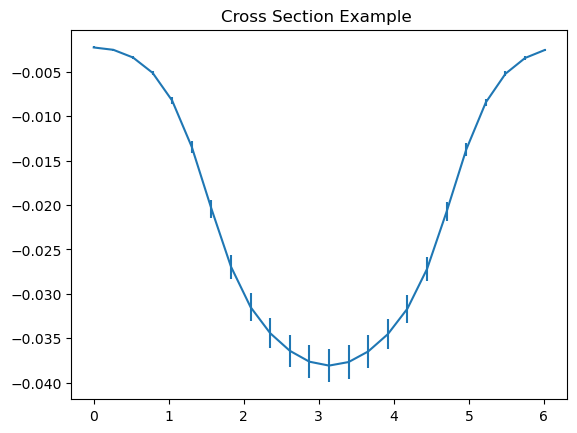

In [40]:

import matplotlib.pyplot as plt
#the plots 
k=5.75; QQ=2;xB=.62;t=-.17; ImE,ImEtilde=0,0 
phi=np.linspace(0,2*np.pi-2*np.pi/23,24)
#y=QQ/(2*k*M*xB); 
ImH,ReH,ReE,ImHtilde,ReHtilde,ReEtilde=ModKM15_CFFs(QQ,xB,t,k)

BKKM=BHUU(y,M,QQ,xB,t,phi*np.pi/180).real
hol=fnctt.sigmaFUUI(t,y,M,QQ,xB,phi,alpha,beta,el,
                    ReH.real,ReE.real,ReHtilde.real,ReEtilde.real,ImH.real,ImE.real,ImHtilde.real,ImEtilde)
hol2=fnctt.sigmaFUU(t,y,M,QQ,xB,phi,alpha,beta,
                    ReH.real,ReE.real,ReHtilde.real,ReEtilde.real,ImH.real,ImE.real,ImHtilde.real,ImEtilde)
F=BKKM+hol+hol2
#print(F)
#plt.plot(phi,random.gauss(F.real,var*F.real))
plt.errorbar(phi,random.gauss(F.real,var*F.real),yerr=abs(var*F.real))
plt.title('Cross Section Example ')

Text(0.5, 1.0, 'Cross Section Example ')

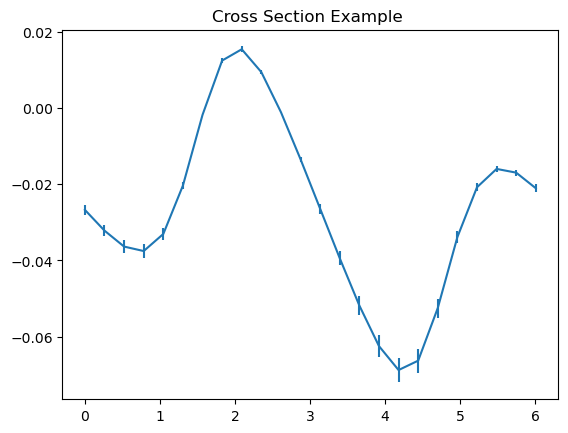

In [13]:
#Graph of LL stuff 
import matplotlib.pyplot as plt
#the plots 
k=5.75; QQ=2;xB=.62;t=-.17; ImE,ImEtilde=0,0 
phi=np.linspace(0,2*np.pi-2*np.pi/23,24)
#y=QQ/(2*k*M*xB); 
ImH,ReH,ReE,ImHtilde,ReHtilde,ReEtilde=ModKM15_CFFs(QQ,xB,t,k)

BKKM=BHLL(y,M,QQ,xB,t,phi*np.pi/180,electronthing,lambdae,LambdaP).real
hol=fnctt.sigmaFLLI(t,y,M,QQ,xB,phi,alpha,beta,el,h,DeltaL,
                    ReH.real,ReE.real,ReHtilde.real,ReEtilde.real,ImH.real,ImE.real,ImHtilde.real,ImEtilde)
hol2=fnctt.sigmaFLL(t,y,M,QQ,xB,phi,alpha,beta,DeltaL,h,
                    ReH.real,ReE.real,ReHtilde.real,ReEtilde.real,ImH.real,ImE.real,ImHtilde.real,ImEtilde)
F=BKKM+hol+hol2
#print(F)
#plt.plot(phi,random.gauss(F.real,var*F.real))
plt.errorbar(phi,random.gauss(F.real,var*F.real),yerr=abs(var*F.real))
plt.title('Cross Section Example ')

In [8]:
import pandas as pd
#from dvcsfunctions import function as fnctt
import fucntiondvcs as fnctt
import random
#M is mass of proton, alpha,beta,el are parameters, el is related to polerization either +-1, y is defined later
alpha,beta,el,h,DeltaL=1/2,1/2,1,1,1
M=0.938272
#varience from experimental stuf 
var=.05
#these are the kinematics
#QQ[1.49, 8.51], xB[0.33, 0.62], t[-1.37, -0.17], k = 5.75; np.array((rows,columns))
nQQ=np.linspace(1.49,8.51,5);nxB=np.linspace(.33,.62,5);nt=np.linspace(-1.37,-.17,5)
'''#a and c are matrixecs that contain the data, a is dummy that gets rewritten each time for each set of kinematics
#a just  steps through phi, a then get concatenateed onto c along axis 0 
note on y, comes from mathematica code kmag=Simplify[Q/y/\(Gamma), which is y=QQ/(k*2*M*xB), so depends on QQ/(k*2*M*xB)'''
c=np.zeros((24,22))
ImE,ImEtilde=0,0 
jjj=0
for Qs in range(np.size(nQQ)):
    for xs in range(np.size(nxB)):
        for ts in range(np.size(nt)):
            a=np.zeros((24,22))
            jjj=jjj+1
            for i in range(24):
                y=nQQ[Qs]/(2*k*M*nxB[xs])
                ImH,ReH,ReE,ImHtilde,ReHtilde,ReEtilde=ModKM15_CFFs(nQQ[Qs],nxB[xs],nt[ts],k)
                a[i,0]=jjj
                a[i,1]=nQQ[Qs];a[i,2]=nxB[xs];a[i,3]=nt[ts];a[i,4]=k
                a[i,5]=i*(2*np.pi)/24*180/np.pi
                #BHUU is in degrees, everything else is in radians 
                BKKM=BHUU(y,M,QQ,xB,t,i*(2*np.pi)/24*np.pi/180).real
                hol=fnctt.sigmaFUUI(nt[ts],y,M,nQQ[Qs],nxB[xs],i*(2*np.pi)/24,alpha,beta,el,
                                    ReH.real,ReE.real,ReHtilde.real,ReEtilde.real,ImH.real,ImE.real,ImHtilde.real,ImEtilde)
                hol2=fnctt.sigmaFUU(nt[ts],y,M,nQQ[Qs],nxB[xs],i*(2*np.pi)/24,alpha,beta,
                                    ReH.real,ReE.real,ReHtilde.real,ReEtilde.real,ImH.real,ImE.real,ImHtilde.real,ImEtilde)
                F=BKKM+hol+hol2
                a[i,6]=random.gauss(F.real,var*F.real)
                a[i,7]=var*F.real
                #add the beam asymentruy equation 35, and equation 39, and 46
                #ALU is equation 35
                ALU=((el*fnctt.sigmaFLUI(nt[ts],y,M,nQQ[Qs],nxB[xs],i*(2*np.pi)/24,alpha,beta,el,h,ReH.real,
                                   ReE.real,ReHtilde.real,ReEtilde.real,ImH.real,ImE.real,ImHtilde.real,ImEtilde)+
                     fnctt.sigmaFLU())/(BKKM+el*hol+hol2)).real
                a[i,8]=random.gauss(ALU,var*ALU);a[i,9]=var*ALU
                #AUL is equation 39
                AUL= ((el*fnctt.sigmaFULI(nt[ts],y,M,nQQ[Qs],nxB[xs],i*(2*np.pi)/24,alpha,beta,el,DeltaL,ReH.real,ReE.real,
                                          ReHtilde.real,ReEtilde.real,ImH.real,ImE.real,ImHtilde.real,ImEtilde)+
                      fnctt.sigmaFUL())/(BKKM+el*hol+hol2)).real
                a[i,10]=random.gauss(AUL,var*AUL); a[i,11]=var*AUL
                #ALL is equation 46
                ALL= ((BKKM+el*fnctt.sigmaFLLI(nt[ts],y,M,nQQ[Qs],nxB[xs],i*(2*np.pi)/24,alpha,beta,el,h,DeltaL,ReH.real,
                                               ReE.real,ReHtilde.real,ReEtilde.real,ImH.real,ImE.real,ImHtilde.real,ImEtilde)+
                     fnctt.sigmaFLL(nt[ts],y,M,nQQ[Qs],nxB[xs],i*(2*np.pi)/24,alpha,beta,DeltaL,h,ReH.real,ReE.real,
                                    ReHtilde.real,ReEtilde.real,ImH.real,ImE.real,ImHtilde.real,ImEtilde))
                    /(BKKM+el*hol+hol2)).real
                a[i,12]=random.gauss(ALL,var*ALL); a[i,13]= var*ALL
                
                a[i,14]=ReH.real; a[i,15]=ImH.real; a[i,16]=ReE.real; a[i,17]=ImE.real
                a[i,18]=ReHtilde.real; a[i,19]=ImHtilde.real; a[i,20]=ReEtilde.real;a[i,21]=ImEtilde
                
                #sigmaFUUI(t,y,M,QQ,xB,phi,alpha,beta,el,H,E,Ht,Et,Hc,Ec,Htc,Etc):
            c=np.concatenate((c,a),axis=0)
for _ in range(24): c=np.delete(c,0,0)
b=pd.DataFrame(c,columns=['index','QQ','xB','t','k','phi','F','F Error','ALU','ALU error','AUL','AUL error','ALL','ALL error',
                          'ReH','ImH','ReE','ImE','ReHt','ImHt','ReEt','ImEt'])
b.to_csv('vulcann.csv',index='False')  
#add the beam asymentruy equation 35, and equation 39, and 46
#add the t thing 